In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from time import time
from tqdm import tqdm
import datetime as dt
from collections import Counter

# text processing
import re
with open('stopwords-de_no-parties.json', 'r') as file:
    stopwords_de = json.load(file)
from  nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim.test.utils import datapath
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover

In [3]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [2]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using gensim 

- take all words from clean text
    - stem them
    - make them lower-case
    - take only words longer than 2 characters
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
    - prune the dictionary: use only words that occur more than 10 times in the corpus
- run through a couple of topics numbers and look at metrics: coherence score and model perplexity
    -> chose number of topics where metrics look best
- run lda on corpus, evaluate model and visualize it

In [3]:
save = False

path_com_corpus = '../Data/lda_nonlp_stemmed_pruned_ccorpus.pkl'
path_corpus = '../Data/lda_nonlp__stemmed_pruned_corpus.pkl'
path_dic = '../Data/lda_nonlp__stemmed_pruned_dic.pkl'

if save:
            
    text = all_data.loc[:, 'clean_text']

    document = []
    corpus_full = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
        
    for doc in document:
        sub_doc = []
        for word in doc.split():
            if ((word.lower() not in stopwords_de)
                and (len(word) > 2)):
                word = stemmer.stem(word)
                sub_doc.append(word)
        corpus_full.append(sub_doc)


    corpus = dict_pruning(corpus_full, 10)
    common_dictionary = corpora.Dictionary(corpus, prune_at=10000)
    common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
    
    with open(path_com_corpus, 'wb') as fid:
        print('dumping it')
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)
        print('everything dumped')
else:
    with open(path_com_corpus, 'rb') as fid:
        print('loading it')
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)
        print('everything loaded')

loading it
everything loaded


In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.4,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
        print('At {} of {}'.format(num_topics, limit))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

# compute_coherence_values(common_dictionary, common_corpus, corpus, limit=100, start=80, step=1)

Subsequent visual evaluation of the model shows that model perplexity in this case is more reliable:
chose the point where curve starts to flatten (elbow) - this will give the best result

In [7]:
lda = LdaModel(common_corpus, 
               num_topics=83, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.4,
               per_word_topics=True,
               iterations=70)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

KeyboardInterrupt: 

https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [4]:
save_model = False
path = '../Models/lda_nonlp_stemmed_pruned_lda-model.pkl'
if save_model:
    with open(path, 'wb') as fid:
        pickle.dump(lda, fid)
else:
    with open(path, 'rb') as fid:
        lda = pickle.load(fid)

In [5]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
save_topics = False
path = '../Data/lda_nonlp_stemmed_pruned_lda_topics.pkl'

if save_topics:
    
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)
    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    # reindex the initial dataframe, make list of initial df and topics df and concatenate both
    all_data_reindexed = all_data.reset_index(drop=True)
    df_list = [df_dominant_topic,all_data_reindexed]
    full_df = pd.concat(df_list, axis=1)
    # make the resulting dataframe datetime indexed again and throw away unwanted columns
    full_df.index = full_df['created_at']
    full_df = full_df.drop(['stemmed', 'tags', 'parties', 'created_at', 'mentions'], axis=1)
    full_df['topic'] = full_df['Dominant_Topic'].map(lambda x: x.replace('nan', np.NaN) if isinstance(x, str) else x)
    # show
    full_df.head()

    with open(path, 'wb') as fid:
        pickle.dump(full_df, fid)

# else:
#     with open(path, 'rb') as fid:
#         full_df = pickle.load(fid)

In [229]:
x = 'nan'
isinstance(x, str)

True

In [249]:
full_df.topic.value_counts(dropna=False)

NaN      86385
 28.0     4383
 65.0     2043
 24.0     1455
 37.0      783
 25.0      671
 7.0       577
 16.0      516
 29.0      486
 12.0      470
 52.0      467
 30.0      428
 69.0      410
 47.0      393
 11.0      392
 70.0      383
 75.0      363
 1.0       357
 54.0      341
 59.0      338
 51.0      328
 0.0       325
 77.0      305
 46.0      305
 48.0      298
 67.0      296
 68.0      292
 26.0      289
 61.0      287
 9.0       285
         ...  
 5.0       202
 27.0      201
 20.0      199
 33.0      197
 15.0      197
 57.0      196
 62.0      195
 19.0      194
 72.0      193
 3.0       185
 79.0      183
 76.0      182
 2.0       180
 73.0      179
 14.0      178
 38.0      171
 43.0      168
 71.0      167
 10.0      162
 58.0      160
 53.0      159
 64.0      157
 21.0      154
 6.0       154
 41.0      152
 78.0      149
 34.0      137
 50.0      136
 13.0      135
 35.0      135
Name: topic, Length: 84, dtype: int64

In [7]:
tops = Counter(full_df.Dominant_Topic)

In [8]:
topc_per = full_df.loc[:, 'Topic_Perc_Contrib'].describe()

In [9]:
topc_per

count    29359.000000
mean         0.645033
std          0.204604
min          0.400000
25%          0.480600
50%          0.532000
75%          0.924300
max          0.998700
Name: Topic_Perc_Contrib, dtype: float64

In [92]:
full_df.shape

(115745, 7)

In [98]:
high_sec_topcis.shape

(14244, 7)

In [250]:
topic_counts = full_df.groupby(full_df.index.date)['topic'].value_counts().reset_index(name='counts')

topic_counts = topic_counts.set_index(pd.DatetimeIndex(topic_counts['level_0'])).drop(columns='level_0')

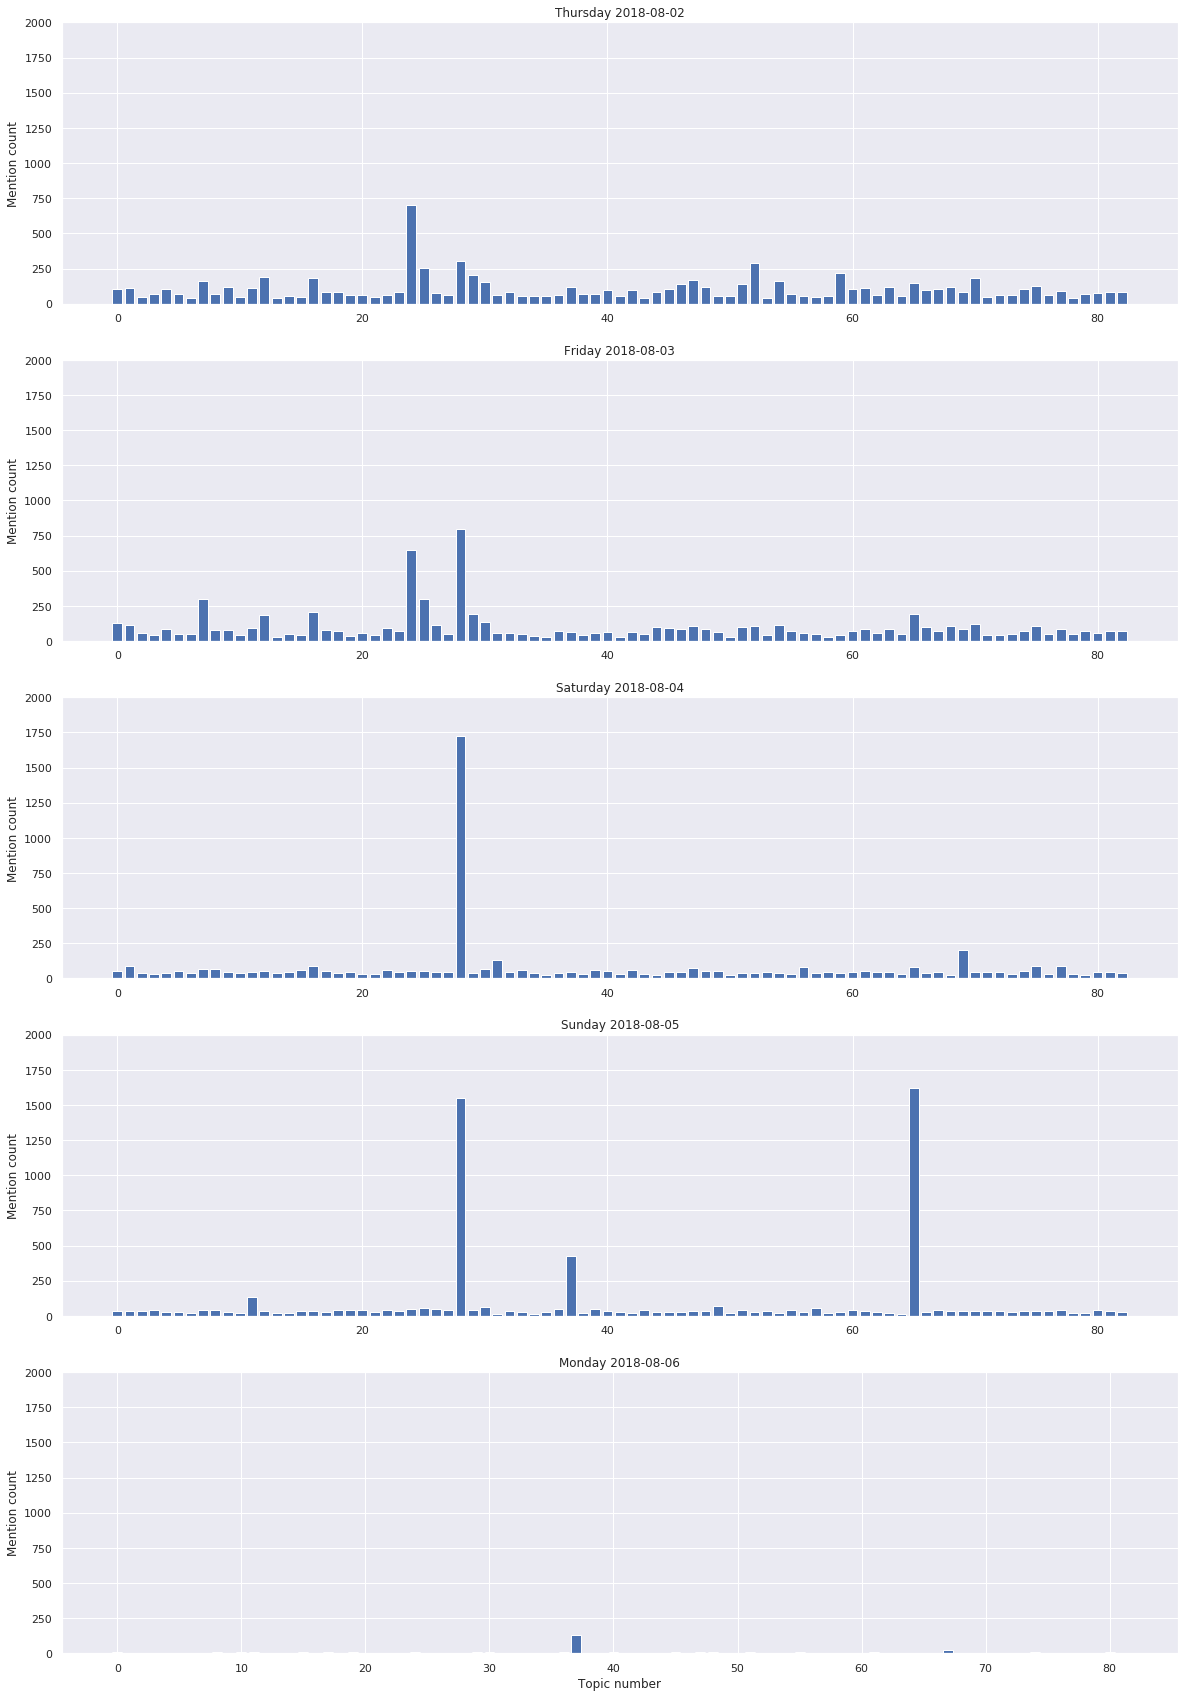

In [251]:
def topic_plot(df, n_horizontal, n_vertical):
    dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dates = df.index.unique()
    
    fig, ax = plt.subplots(n_horizontal, n_vertical, figsize=(20, 30))

    for i, date in enumerate(dates):
        ax[i].bar(df.loc[date, 'topic'], df.loc[date, 'counts'], label=date) 
        ax[i].set_ylim(0, 2000)
        ax[i].set_title('{} {}'.format(dow[date.dayofweek], date.date()))
        ax[i].set_ylabel('Mention count')
    plt.xlabel('Topic number')
    plt.show()

topic_plot(topic_counts, 5, 1)

In [252]:
def print_largest_topics(topicsdf, fulldf, topic_prob=0.85, n_text=5):
    largest_tpcs = topicsdf.copy().reset_index().reset_index()
    frequent_topcs = largest_tpcs.groupby('level_0')['counts'].nlargest(5).reset_index().merge(
                 largest_tpcs[['index', 'topic']], left_on='level_1', right_on='index').drop(
                 columns='level_1')
    frequent_topcs_list = frequent_topcs.topic.unique()
    
    for topic in freq_topcs_list:
        print(topic, fulldf[['Keywords']][fulldf['topic'] == topic].values[0])
        print(fulldf[['Topic_Perc_Contrib', 'clean_text']][(fulldf['topic'] == topic) & (fulldf['Topic_Perc_Contrib'] > topic_prob)].values[n_text])

print_largest_topics(topic_counts, full_df)

24.0 ['waehl, stimm, gewaehlt, hoer, richtung, partei, kritisch, gesicht, privat, plattform']
[0.9606000185012817
 '    Wer  kontrolliert  es  ob    oder      oder  mehr  sind  Machen  sie  eine  Strichliste  und  nach  welchen  Kriterien  wird  entschieden  Das  ist  alles  wieder  nur  unausgegorener  Mist   Aber  was  kann  man  von  Merkel  amp  Co  anderes  erwarten  ARMES   Leute  denkt  daran  wenn  ihr  zur  LTW  waehlt   ']
28.0 ['fdp, csu, cdu, spd, bild, gruen, waer, partei, waehl, spani']
[0.9733999967575073
 ' Burka  Verbot  in          Immer  mehr  Laender  in   Europa  wachen  auf    AfD  fordert  das  und  noch  viel  mehr  auch  fuer       Islamisierung  stoppen   einLink ']
52.0 ['jung, oeffent, alternativ, spinn, leist, schick, hitl, tipp, feiern, niedersachs']
[0.9733999967575073
 'Natuerlich  sieht  die  AFD  das  nicht  als  Problem  an   Sollte  die  afd  recht  haben  mit  ihrer  Aussage   erwarte  ich  eine  Beobachtung  der  Bundeswehr  durch  den  Verfassungs

In [265]:
full_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,full_text,clean_text,user_id,topic
created_at,,,,,,,,,
2018-08-02 00:00:14,0,28.0,0.7995,"fdp, csu, cdu, spd, bild, gruen, waer, partei,...","[sami, migrant, fluechtling, weisst, demokrati...",@BILD Für Sami A macht man Rundflüge. gute Mig...,Fuer Sami A macht man Rundfluege gute ...,884513792062881794,28.0
2018-08-02 00:00:32,1,25.0,0.6144,"brauch, les, rassist, mitglied, koennt, teil, ...","[noafd, schreib, argument, lief, afd, waehl]",@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,NoAFD schreiben aber keine Argumente li...,702527680722419712,25.0
2018-08-02 00:00:32,2,63.0,0.7935,"baeum, erfolgreich, sterb, unternehm, kauf, vo...","[kenn, reps, bad, wuerttemberg, trifft]",RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...,Ich kenne nur die REPs Baden Wuer...,3438043463,63.0
2018-08-02 00:01:33,3,0.0,0.4405,"sag, ide, schad, nam, normal, hilft, fan, hey,...","[dritt, kauf, nehm, ungleich, nehm, kauf, abst...",@NeotherealNeo @vonduessel @AfD @AndreasKalbit...,Drittens in kauf nehmen ist ungleich ...,846319908254367744,0.0
2018-08-02 00:02:08,4,29.0,0.5657,"fluechtling, gemeinsam, findet, antwort, nenn,...","[wert, afd, versteh, afdwirkt]",Damit wir die Werte #AfD besser verstehen. #Af...,Damit wir die Werte AfD besser verstehe...,165708897,29.0


In [287]:
user_tops = full_df.dropna(subset=['topic']).groupby('user_id')['topic'].apply(list)

In [288]:
user_tops

user_id
1000025423361830913                       [28.0, 82.0, 38.0, 42.0, 28.0]
1000031402216259586                                         [70.0, 45.0]
1000045111793934337                                               [28.0]
1000059546482733056                                               [29.0]
1000108511303434240                                         [35.0, 65.0]
1000108800790159360                                               [72.0]
1000253026039468034                                               [30.0]
1000260634968231936                                               [28.0]
1000266924624941056                                               [40.0]
1000362624872321025    [24.0, 81.0, 77.0, 7.0, 24.0, 60.0, 24.0, 33.0...
1000441685665632256                                               [67.0]
1000481842443837440    [0.0, 24.0, 58.0, 22.0, 28.0, 57.0, 70.0, 31.0...
1000510254503821318    [17.0, 31.0, 16.0, 21.0, 59.0, 49.0, 79.0, 16....
1000648722152394752                        

In [189]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'topics']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]

NameError: name 'df_part' is not defined

In [35]:
test_df = pd.read_pickle('../Data/all_data_lda.pickle')

In [36]:
test_df.head()

,created_at,full_text,tags,mentions,clean_text,parties,stemmed,user_id
created_at,,,,,,,,
2018-08-02 00:00:14,2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794
2018-08-02 00:00:32,2018-08-02 00:00:32,@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,[],"[bembelpix, AfD_Hessen]",NoAFD schreiben aber keine Argumente li...,[AfD],noafd schreib aber kein argument lief ...,702527680722419712
2018-08-02 00:00:32,2018-08-02 00:00:32,RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...,[],"[Walnusskipferl, AssetsKater72, dr_ecksack_, i...",Ich kenne nur die REPs Baden Wuer...,[],ich kenn nur die reps bad wuertte...,3438043463
2018-08-02 00:01:33,2018-08-02 00:01:33,@NeotherealNeo @vonduessel @AfD @AndreasKalbit...,[],"[NeotherealNeo, vonduessel, AfD, AndreasKalbitz]",Drittens in kauf nehmen ist ungleich ...,[AfD],dritt in kauf nehm ist ungleich woll...,846319908254367744
2018-08-02 00:02:08,2018-08-02 00:02:08,Damit wir die Werte #AfD besser verstehen. #Af...,"[AfD, AfDwirkt]",[],Damit wir die Werte AfD besser verstehe...,[AfD],damit wir die wert afd bess versteh ...,165708897
